<a href="https://colab.research.google.com/github/seDavo01/RA_project/blob/main/%5BRA%5Dppddltossg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RA project

Davide di Ienno  
1691101  
diienno.1691101@studenti.uniroma1.it  


This is a notebook to use and test the implmentation, starting from pddl files (from another repository), generating from it a simple stochastic game and solving it with a linear programming algorithm. 

## Initialize environment

clone probabilistic branch of the planner-for-relevant-policies: we are going to use its sample problems to test the code

In [52]:
! git clone -b probabilistic https://github.com/QuMuLab/planner-for-relevant-policies

fatal: destination path 'planner-for-relevant-policies' already exists and is not an empty directory.


clone the project with the source code and install needed libraries

In [53]:
! git clone https://github.com/seDavo01/RA_project.git

fatal: destination path 'RA_project' already exists and is not an empty directory.


In [54]:
! python3 -m pip install -r RA_project/requirements.txt

In [55]:
! mkdir output

mkdir: cannot create directory ‘output’: File exists


## Import libraries and files

In [56]:
import sys
sys.path.append('RA_project/src/')

import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import pulp as lp

import ppddltossg

## Select domain and problem 

Read ppddl domain and problem.
The ones here were all tested and works; consider that using bigger problem files is not a good idea with this implementation (that generate all the states).
There is a time limitation equal to 300 seconds.

Run the block of the chosen problem, consider that only the climber problem can be later represented in a graph using networkx (because it has only a few nodes).

Blocksworld

In [57]:
domain_file = 'planner-for-relevant-policies/prob-benchmarks/blocksworld/domain.pddl'
problem_file = 'planner-for-relevant-policies/prob-benchmarks/blocksworld/p01.pddl'

Tire problem

In [58]:
domain_file = 'planner-for-relevant-policies/prob-benchmarks/tire-problem/tire_domain.pddl'
problem_file = 'planner-for-relevant-policies/prob-benchmarks/tire-problem/tire_problem.pddl'

Triangle tire world

In [59]:
domain_file = 'planner-for-relevant-policies/prob-benchmarks/triangle-tireworld/domain.pddl'
problem_file = 'planner-for-relevant-policies/prob-benchmarks/triangle-tireworld/p03.pddl'

Climber

In [60]:
domain_file = 'planner-for-relevant-policies/prob-benchmarks/climber/climber_domain.pddl'
problem_file = 'planner-for-relevant-policies/prob-benchmarks/climber/climber_problem.pddl'

## PPDDL to SSG

With the chosen domain, read the files, generate the states and save them as a simple stochastic game in the particular case of one player and the average nodes.

The output are two csv with nodes and edges, they can be easily imported with pandas later.

In [61]:
ppddltossg.main(domain_file, problem_file)

generating: |          | 0/300 [00:00<?] [tot-n=0, goal=0]


## SSG

If there are too many nodes it is useless to represent them, but the climber domain is a nice way to show how the result look like.  
  
But first, we need to read nodes and edges just generated.
Talking about nodes, n is the identifier of the node, -1 is for the sink, 0 is the node that corresponds to the starting state defined in the 'problem.pddl'. The other numbers are given in the same order as the nodes are generated. Consider that the algorithm to generate states (and so, nodes) is a breath-first algorithm where the duplicates are discarded.  
The type can be:  
 - '1-s' for the sink  
 - 'one' for the player, we assume here that he is the max player  
 - 'avg' for ann average node.

In [62]:
nodes_df = pd.read_csv('output/nodes.csv', index_col=0)
nodes_df.head()

,n,type
0,-1.0,1-s
1,0.0,one
2,1.0,avg
3,2.0,one
4,3.0,one


Edges are characterized by:  
 - 'from' that indicates the starting node  
 - 'to' for the destination  
 - 'prob' for the probability, considering that where it is not needed (i.e. the starting node is handled by the max player) it is 1 and it is not used (so, it's a placeholder)

In [63]:
edges_df = pd.read_csv('output/edges.csv', index_col=0)
edges_df.head()

,from,to,prob
0,0.0,1.0,1.0
1,1.0,2.0,0.4
2,1.0,3.0,0.6
3,0.0,4.0,1.0
4,2.0,2.0,1.0


### Graph

With the climber domain it is nice to see the related graph.  
Inside the nodes represented are de ids readed before.
The color schema is the following:  
 - blue for nodes of the max player  
 - red for average nodes  
 - green for the sink node of the max player.  
   
Note how there are probabilities, where the useful ones are in the edges from the average nodes.
It is also interesting to see how there are nodes, such as 6 and 2, are a dead-end. 

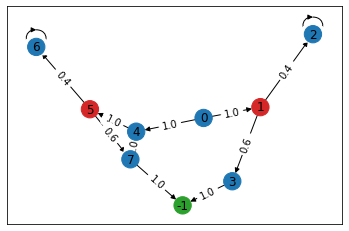

In [64]:
if 'climber' in domain_file:
    nodes_colors = list()
    nodes_labels = dict()
    edges_labels = dict()
    DG = nx.DiGraph()
    DG.add_nodes_from(nodes_df['n'])
    for _n, _type, in zip(nodes_df['n'], nodes_df['type']):
        nodes_labels[int(_n)] = str(int(_n))
        if _type == 'one':
            c = "tab:blue"
        elif _type == 'avg':
            c = "tab:red"
        else:
            c = "tab:green"
        nodes_colors.append(c)
    for _from, _to, _prob in zip(edges_df['from'], edges_df['to'], edges_df['prob']):
        edge = (int(_from), int(_to))
        DG.add_edges_from([edge])
        edges_labels[edge] = _prob

    pos = nx.spectral_layout(DG)

    subax1 = plt.subplot(111)
    _ = nx.draw_networkx_nodes(DG, pos=pos, node_color=nodes_colors)
    _ = nx.draw_networkx_labels(DG, pos=pos, labels=nodes_labels)
    _ = nx.draw_networkx_edges(DG, pos=pos)
    _ = nx.draw_networkx_edge_labels(DG, pos=pos, edge_labels=edges_labels)

## Solver

We can use a linear programming algorithm to solve our simple stochastic game with only max and average vertices.  
The objective is to minimize $\sum_{x\in{}V}{v(x)}$, where V are all the vertices.
The constraints are in part generalized with respect to the "classical" max+avg problem, mainly because the probabilities are not always 0.5. Such constraints are:  
 - $v(x)\geq{}v(y)$ if x is a max node and the edge x,y exist  
 - $v(x)\geq{}\sum_{y}{p(x,y)v(y)}$ if x is an avg node, where p(x,y) is the probability associated to the edge between x and y (note how there are no limitations in the number of nodes and in their associated probabilities)
 - $v(x)=p(x)$ if x is the sink  
 - $v(x)\geq{}0$ for all vertices x  


To solve this linear problem it was used a library called [PuLP](https://pypi.org/project/PuLP/).  
The problem is initialized with the conditions presented above and the minimization problem is solved with its (of pulp) solver.

In [65]:
variables = list()
nodes = list()

for n, t in zip(nodes_df['n'], nodes_df['type']):
    variables.append(lp.LpVariable('x'+str(int(n)), lowBound = 0))
    nodes.append((n, t))

Lp_prob = lp.LpProblem('Problem', lp.LpMinimize) 
exp = 0
for v in variables:
    exp += v
Lp_prob += exp

for n in nodes:
    temp_df = edges_df['from'] == n[0]
    temp_df = edges_df[temp_df]
    if n[1] == 'one':
        for f, t in zip(temp_df['from'], temp_df['to']):
            if f != t:
                Lp_prob += variables[int(f)+1] >= variables[int(t)+1]
    elif n[1] == 'avg':
        probs = temp_df['prob'].tolist()
        tos = temp_df['to'].tolist()
        Lp_prob += variables[int(n[0])+1] >= [prob * variables[int(to)+1] for prob, to in zip(probs, tos)]
    elif n[1] == '1-s':
        Lp_prob += variables[int(n[0])+1] == 100

status = Lp_prob.solve()
print('linear problem status: ' + lp.LpStatus[status])
print('probability (over 100) of starting node (state): ' + str(lp.value(variables[1])))
print('value: ' + str(lp.value(Lp_prob.objective)))

linear problem status: Optimal
probability (over 100) of starting node (state): 100.0
value: 620.0
